Night Sky Object Identification and Mapping

In [156]:
from astropy.coordinates import SkyCoord
import astropy.units as u
import numpy as np
import random
import cv2
import math
from typing import List, Tuple
import matplotlib.pyplot as plt
import scipy.ndimage as ndi
from scipy.stats import rv_discrete
from skimage.filters import gaussian
from scipy.ndimage import convolve

#TO DO LIST


*   Fix noise generation DONE
*   Made star blur scaleas a sqrt DONE
*   Fix higher magnification resulting in overly blurry images and small number of stars DONE WITH PREVIOUS
*   Work on object generation DONE
*   Implement a way to speed up the code & research neural nets before creating the dataset



#Calculating images

##Star code

In [181]:
stars_per_magnitude = {
    2.0: 48,
    3.0: 171,
    4.0: 513,
    5.0: 1602,
    6.0: 4800,
    7.0: 14000,
    8.0: 42000,
    9.0: 121000,
    10.0: 340000,
    11.0: 725346,
    12.0: 1374412,
    13.0: 2378009,
    14.0: 3844017,
    15.0: 5894386,
    16.0: 8665135,
    17.0: 12306357,
    18.0: 16982212,
    19.0: 22870933,
    20.0: 30164822, #used regression to find those above 20
    21.0: 3.997534295069156e7,
    22.0: 5.192083183249308e7,
    23.0: 6.6644844115279734e7,
    24.0: 8.462953308674893e7,
    25.0: 1.0641478627977826e8,
    26.0: 1.3260229977121532e8,
    27.0: 1.6385975616052195e8,
    28.0: 2.009251045589161e8,
}

def count_stars_in_range(start_magnitude: float, end_magnitude: float):
    total_stars = 0
    for magnitude in range(int(start_magnitude), int(end_magnitude) + 1):
        total_stars += stars_per_magnitude.get(magnitude, 0)
    return total_stars

def generate_stars(min_magnitude, percent_of_sky):
    # Number of stars to generate
    num_stars = int(count_stars_in_range(0, min_magnitude) * percent_of_sky)

    # List to hold the ranges of magnitudes
    magnitude_ranges = [(i, i+1, count_stars_in_range(i, i+1)*percent_of_sky) for i in range(0, min_magnitude)]

    stars = []
    for _ in range(num_stars):
        # Generate a random number to determine the magnitude bracket
        rand_number = random.random() * num_stars

        # Determine the bracket the random number falls into
        total = 0
        for mag_range in magnitude_ranges:
            total += mag_range[2]
            if rand_number <= total:
                break

        # Assign a magnitude to the star within the selected range
        magnitude = random.uniform(mag_range[0], mag_range[1])

        # Assign random coordinates to the star
        coord_x = random.random() * 100  # Percentage from left to right
        coord_y = random.random() * 100  # Percentage from bottom to top

        # Append the star (represented as a dictionary) to the list
        stars.append({"magnitude": magnitude, "coordinates": (coord_x, coord_y)})

    return stars

def add_diffraction_spikes(image, center, brightness, magnitude, magnitude_threshold, num_spikes, glow_radius):
    # Only add spikes to stars brighter than a certain threshold
    if magnitude > magnitude_threshold:
        return image

    # Define the base spike length
    base_spike_length = 2 * glow_radius

    # Calculate a factor to increase the spike length based on the star's magnitude
    magnitude_factor = 1.2 ** (magnitude_threshold - magnitude)

    # Calculate the final spike length including the magnitude factor
    final_spike_length = int(base_spike_length * magnitude_factor)

    # Add the spikes
    for i in range(num_spikes):
        # Calculate the direction of the spike
        angle = 2 * math.pi * i / num_spikes
        direction = (math.cos(angle), math.sin(angle))

        # Draw the spike on the image pixel by pixel
        for j in range(final_spike_length):
            position = (
                int(center[0] + direction[0] * j),
                int(center[1] + direction[1] * j)
            )
            # Fade brightness in the latter half of the spike
            if j >= final_spike_length / 2:
                pixel_brightness = brightness * (1 - 2 * (j - final_spike_length / 2) / final_spike_length)
            else:
                pixel_brightness = brightness

            # Check if the position is within the image boundaries before setting the pixel value
            if 0 <= position[0] < image.shape[1] and 0 <= position[1] < image.shape[0]:
                image[position[1], position[0]] = min(255, image[position[1], position[0]] + int(pixel_brightness))

    return image




def create_star_image(stars, celestial_object, image_size, exposure_time, magnitude_threshold, num_spikes):
    # Create a black image
    image = np.zeros(image_size, dtype=np.uint8)

    # Add the celestial object to the stars list
    stars = stars + [celestial_object]

    # Calculate the maximum and minimum star magnitude
    min_magnitude = min(star['magnitude'] for star in stars)
    max_magnitude = max(star['magnitude'] for star in stars)

    # List to store the stars that need diffraction spikes
    stars_with_spikes = []

    # Map each star onto the image
    for star in stars:
        if star == celestial_object:
            continue  # Skip the celestial object

        # Calculate star brightness
        if max_magnitude == min_magnitude:
            brightness = 255
        else:
            brightness = int(((max_magnitude - star['magnitude']) / (max_magnitude - min_magnitude)) * 255)

        # Calculate the position of the star in the image
        position = (int(star['coordinates'][1] / 100 * image_size[1]),
                    int(star['coordinates'][0] / 100 * image_size[0]))

        # Add a glow around the star
        glow_radius = calculate_glow_radius(star['magnitude'], max_magnitude, exposure_time)
        image = add_glow(image, position, brightness, glow_radius)

        # Set the pixel at the star's position to the star's brightness
        image[position[1], position[0]] = min(255, image[position[1], position[0]] + brightness)

        # Add star to the list of stars that need diffraction spikes if it meets the magnitude threshold
        if star['magnitude'] <= magnitude_threshold:
            stars_with_spikes.append((position, brightness, star['magnitude'], glow_radius))

    # Add diffraction spikes around the stars
    for position, brightness, magnitude, glow_radius in stars_with_spikes:
        image = add_diffraction_spikes(image, position, brightness, magnitude, magnitude_threshold, num_spikes, glow_radius)

    return image



def calculate_glow_radius(star_magnitude, max_magnitude, exposure_time):
    base_magnitude = 0  # or another value to scale the radius
    relative_magnitude = max_magnitude - star_magnitude
    # calculate base 10 logarithm of relative brightness, and scale it by a factor
    glow_radius = int(0.1 * np.log10(2.5**relative_magnitude) * np.sqrt(exposure_time))  # Using square root of exposure time
    return glow_radius


def add_glow(image, center, brightness, radius):
    # Calculate the square area to consider for the glow
    min_x = max(0, center[0] - radius)
    max_x = min(image.shape[1], center[0] + radius)
    min_y = max(0, center[1] - radius)
    max_y = min(image.shape[0], center[1] + radius)

    # Iterate over the area and add the glow
    for x in range(min_x, max_x):
        for y in range(min_y, max_y):
            # Calculate the distance to the center of the glow
            distance = np.sqrt((x - center[0])**2 + (y - center[1])**2)

            # Calculate the glow brightness
            glow_brightness = int(brightness * (1 - distance / radius))
            glow_brightness = max(0, glow_brightness)  # make sure the brightness never goes below zero

            # Add the glow to the pixel
            if (y, x) == center:
                image[y, x] = glow_brightness
            else:
                image[y, x] = min(255, image[y, x] + glow_brightness)

    return image

##Object code

In [168]:
import math
from typing import List, Tuple

def calculate_spatial_data(fov_deg: float, position_data: List[Tuple[float, Tuple[int, int]]], diameter: float, image_width: int) -> None:
    # convert fov to radians
    fov_rad = math.radians(fov_deg)
    G = 6.67430e-11  # gravitational constant in m^3 kg^-1 s^-2
    M_sun = 1.989e30  # mass of the sun in kg
    time_difference = position_data[-1][0] - position_data[0][0]

    sum_square_diff = 0
    last_angle = None
    for data in position_data:
        time, position = data
        angle = tuple(math.radians(coord / 100 * fov_deg) for coord in position)

        if last_angle is not None:
            dx = angle[0] - last_angle[0]
            dy = angle[1] - last_angle[1]
            sum_square_diff += dx**2 + dy**2
        last_angle = angle

    total_angular_movement_rad = math.sqrt(sum_square_diff)
    print(f"The object moved {math.degrees(total_angular_movement_rad)} degrees.")

    # Calculate the total time for a full 2pi radian orbit
    orbital_period_hours = (2*math.pi / total_angular_movement_rad) * time_difference / 3600
    print(f"The estimated orbital period is {orbital_period_hours} hours.")

    # Calculate the semi-major axis using Kepler's third law
    orbital_period_seconds = orbital_period_hours * 3600  # convert period to seconds
    sma = ((G * M_sun * orbital_period_seconds**2) / (4 * math.pi**2))**(1/3)
    print(f"The estimated semi-major axis is {sma} meters.")

    # Calculate the angular size
    A_rad = diameter / sma
    A_deg = math.degrees(A_rad)
    pixelWidth = (image_width / fov_deg)*A_deg # Image width in pixels.
    print(f"The estimated angular size is {A_deg} degrees - which should be {pixelWidth} pixels wide.")


# Example usage
fov_deg = 1.2286442307692307
position_data = [(0, (25, 25)), (3020, (26, 27))]
diameter = 58232*2*3
image_width = 800

calculate_spatial_data(fov_deg, position_data, diameter, image_width)

The object moved 0.0274733202016294 degrees.
The estimated orbital period is 10992.48280817871 hours.
The estimated semi-major axis is 173977246835.45837 meters.
The estimated angular size is 0.00011506497176937071 degrees - which should be 0.07492158845515808 pixels wide.


In [207]:
def distribute_brightness(image, position, magnitude, angular_size_deg, fov_deg, image_size, exposure_time, aperture_diameter):
    imageTemp = image.copy()

    # Calculate the brightness using exposure time and aperture
    C = 255 * 10 ** -0.4  # Astronomical Magnitude System constant
    brightness = C * exposure_time * aperture_diameter**2 * 10 ** (-0.4 * magnitude)

    # Convert angular size in degrees to radius in pixels
    radius_pixels = angular_size_deg / fov_deg * image_size[0] / 2

    # Calculate the number of pixels to distribute the brightness over
    n_pixels = math.pi * radius_pixels**2

    # Distribute the brightness uniformly over the pixels
    brightness_per_pixel = brightness / n_pixels

    # Adjust brightness_per_pixel based on magnitude difference
    max_star_magnitude = 14
    magnitude_difference_factor = 10 ** (0.4 * (max_star_magnitude - magnitude))
    brightness_per_pixel *= magnitude_difference_factor

    # Check if brightness per pixel is less than 1
    if brightness_per_pixel < 1:
        brightness_per_pixel = 1

    # Define a list to store the pixels inside the object
    object_pixels = []

    # Loop over all pixels
    for dx in range(-int(radius_pixels), int(radius_pixels) + 1):
        for dy in range(-int(radius_pixels), int(radius_pixels) + 1):
            # Check that the pixel is within the object's area
            if dx**2 + dy**2 <= radius_pixels**2:
                x, y = position[0] + dx, position[1] + dy
                # Check that the pixel is within the image
                if 0 <= x < image_size[0] and 0 <= y < image_size[1]:
                    object_pixels.append((x, y))

    # Now distribute the total brightness over all object pixels
    for (x, y) in object_pixels:
        imageTemp[y, x] = min(255, imageTemp[y, x] + brightness_per_pixel)  # set the brightness, but don't exceed 255

    return imageTemp



def add_object_to_image(image, object_coordinates_percent, object_magnitude, object_diameter_km, sma_of_object_in_AU, fov_deg, exposure_time, aperture_diameter):
    image_size = image.shape

    # Convert from percent to pixels
    object_coordinates_pixels = (int(object_coordinates_percent[0] / 100 * image_size[1]),
                                 int(object_coordinates_percent[1] / 100 * image_size[0]))

    # Calculate the angular size
    angle = angular_size(sma_of_object_in_AU, object_diameter_km)

    # Add the object to the image
    image_with_object = distribute_brightness(image, object_coordinates_pixels, object_magnitude, angle, fov_deg, image_size, exposure_time, aperture_diameter)

    return image_with_object


In [170]:
def add_object_to_stars(stars, object_coordinates, object_magnitude):
    # Create a dictionary representing the object (similar to how the stars are represented)
    object_dict = {"magnitude": object_magnitude, "coordinates": object_coordinates}

    # Append the object to the stars list
    stars.append(object_dict)

    return stars

## Noise code

In [171]:
import numpy as np

def generate_noise_image(image_shape):
    # Generate a random noise image with pixel values in the range [0, 255]
    return np.random.randint(0, 256, image_shape, dtype=np.uint8)

def combine_images_with_noise(image, signal_to_noise_ratio):
    # Convert the image to float to avoid overflow or underflow
    image = np.array(image, dtype=np.float64)

    # Generate a noise image of the same shape as the input image
    noise_image = generate_noise_image(image.shape)

    # Convert the noise image to float
    noise_image = np.array(noise_image, dtype=np.float64)

    # Handle the case where the signal-to-noise ratio is between 0 and 1
    if signal_to_noise_ratio < 1:
        # Create an array of "noise" images and one "good" image
        images = [noise_image] * int(1/signal_to_noise_ratio) + [image]

    # Handle the case where the signal-to-noise ratio is an integer or greater than 1
    else:
        # Split the signal-to-noise ratio into an integer part and a fractional part
        integer_part = int(signal_to_noise_ratio)
        fractional_part = signal_to_noise_ratio - integer_part

        # Create an array of "good" images and one "noise" image
        images = [image] * integer_part + [image*fractional_part, noise_image]

    # Combine the images by calculating their mean
    combined_image = np.mean(images, axis=0)

    # Make sure the image intensity stays within the valid range
    combined_image = np.clip(combined_image, 0, 255)

    # Convert the image back to the original datatype
    combined_image = np.array(combined_image, dtype=np.uint8)

    return combined_image


##Telescope code

In [172]:
def field_of_view(chip_size_mm: float, focal_length_mm: float) -> float:
    # Formula for field of view in arcminutes, considering focal length in mm
    fov = (57.3 * chip_size_mm) / focal_length_mm
    return fov

def check_star_visibility(aperture: float, exposure_time: float):
    # Define parameters
    max_brightness = 255  # Maximum star brightness (8-bit scale)
    magnitude_buckets = create_magnitude_buckets(2, 28)

    # Check star visibility
    for min_magnitude, max_magnitude in magnitude_buckets:  # iterate over each magnitude bucket from dimmest to brightest
        # Determine star brightness based on exposure time and aperture
        brightness = 10 ** (-max_magnitude / 2.5)  # generate a star at the dimmest edge of the current bucket

        # Adjust brightness according to exposure time and aperture
        exposure_factor = exposure_time  # The longer the exposure time, the more light is collected
        aperture_factor = aperture**2  # The effectiveness of aperture is proportional to the square of its diameter
        brightness *= exposure_factor * aperture_factor

        # Make sure brightness is within acceptable limits
        brightness = np.clip(brightness, 0, max_brightness)

        # If the star is bright enough to be seen, record it
        if brightness > 1:  # or whatever threshold you deem appropriate
            return max_magnitude
            break  # Breaks the loop as soon as we find a visible star, assuming all brighter stars are also visible


def create_magnitude_buckets(min_magnitude: int, max_magnitude: int):
    return [(i, i+1) for i in range(max_magnitude-1, min_magnitude-1, -1)]

##Telescope settings

In [238]:
aperture=250
focal_len=1040
exposure_time= 200
chip_size = 23
fov = field_of_view(chip_size, focal_len)
fov2 = fov*fov
percentOfSky = ((fov2)/41253)
print(f"FoV = {fov} degrees which is {fov2} degrees squared or {percentOfSky} % of night sky.")
minMagnitude = check_star_visibility(aperture, exposure_time)
print(minMagnitude)
print(count_stars_in_range(0, minMagnitude)*percentOfSky)

FoV = 1.2672115384615383 degrees which is 1.605825083210059 degrees squared or 3.8926261925437156e-05 % of night sky.
17
1390.126724923779


In [239]:
stars = generate_stars(minMagnitude, percentOfSky)

#Generating images

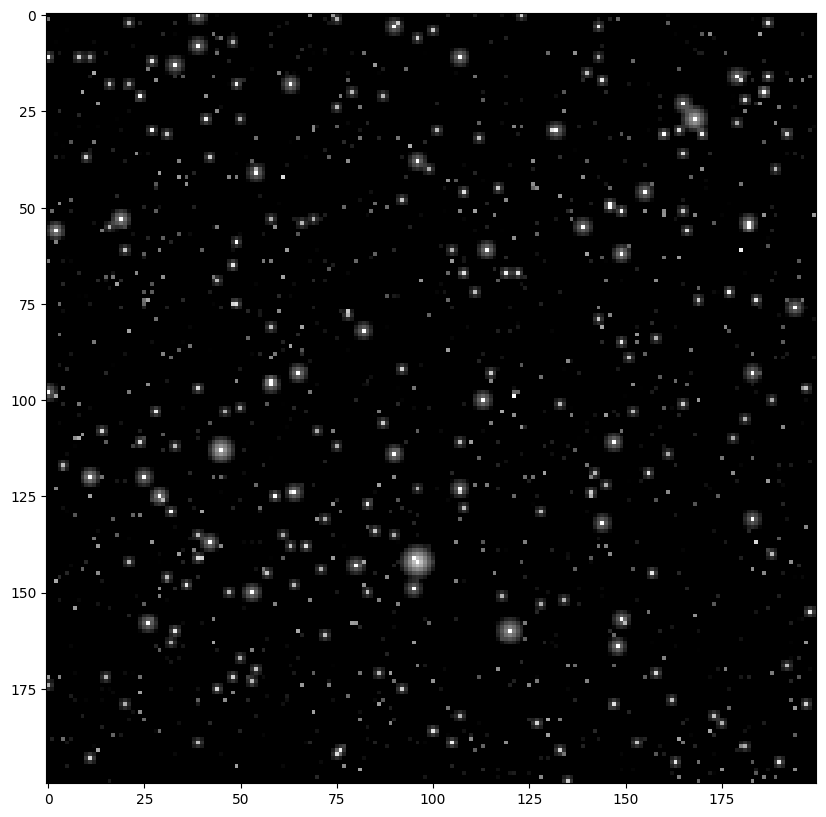

In [240]:
image_size = (200, 200)
object_magnitude = 5.38
celestial_object = {'magnitude': object_magnitude, 'coordinates': (50, 50)}
imageNoNoise = create_star_image(stars, celestial_object, image_size, exposure_time, 0.75*minMagnitude, 0)

plt.figure(figsize=(10, 10))  # adjust the size as needed
plt.imshow(imageNoNoise, cmap='gray')
plt.show()

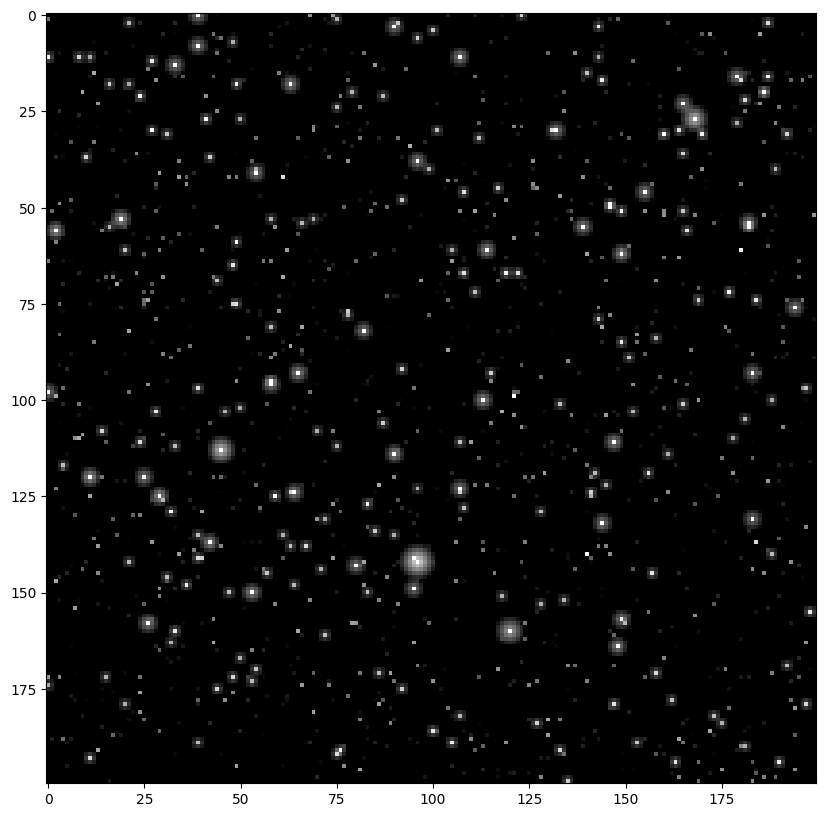

In [241]:
# Define the object
object_coordinates = (70, 70)  # Replace with the actual coordinates
object_diameter_km = 50724  # Replace with the actual diameter
smaObjectAU = 19.165  # Replace with the actual sma

fov_deg = fov  # Field of View in degrees

image_with_object = add_object_to_image(imageNoNoise, object_coordinates, object_magnitude, object_diameter_km, smaObjectAU, fov_deg, exposure_time, aperture/1000)

plt.figure(figsize=(10, 10))  # adjust the size as needed
plt.imshow(image_with_object, cmap='gray')
plt.show()

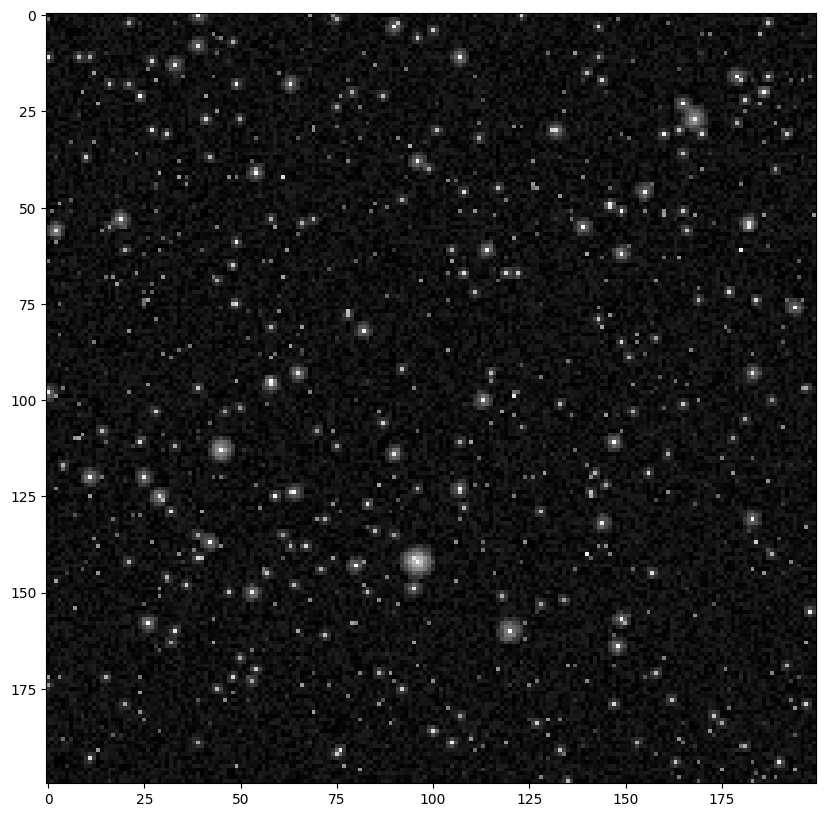

In [242]:
imageNoise = combine_images_with_noise(image_with_object, 7)

plt.figure(figsize=(10, 10))  # adjust the size as needed
plt.imshow(imageNoise, cmap='gray')
plt.show()

##Saving images

In [ ]:
plt.imsave('star_image.png', image, cmap='gray')

In [243]:
for x in range(30):
  tempStars = stars.copy()

  # Define the object
  object_coordinates = (70+(x*0.75), 90-(x*2))  # Replace with the actual coordinates

  imageNoNoise = create_star_image(stars, celestial_object, image_size, exposure_time, 0.75*minMagnitude, 0)

  # Convert from percent to pixels
  object_coordinates_pixels = (int(object_coordinates[0] / 100 * image_size[0]),
                              int(object_coordinates[1] / 100 * image_size[1]))

  image_with_object = add_object_to_image(imageNoNoise, object_coordinates, object_magnitude, object_diameter_km, smaObjectAU, fov_deg, exposure_time, aperture/1000)

  image = combine_images_with_noise(image_with_object, 7)
  plt.imsave(f'star_image_{x}.png', image, cmap='gray')

In [244]:
!rm -r starimg*
!mkdir starimg
!mv star_ima* starimg

In [245]:
from google.colab import files
!zip -r /content/starimg.zip /content/starimg
files.download("/content/starimg.zip")

  adding: content/starimg/ (stored 0%)
  adding: content/starimg/star_image_15.png (deflated 3%)
  adding: content/starimg/star_image_6.png (deflated 3%)
  adding: content/starimg/star_image_24.png (deflated 3%)
  adding: content/starimg/star_image_1.png (deflated 3%)
  adding: content/starimg/star_image_7.png (deflated 3%)
  adding: content/starimg/star_image_18.png (deflated 3%)
  adding: content/starimg/star_image_13.png (deflated 3%)
  adding: content/starimg/star_image_21.png (deflated 3%)
  adding: content/starimg/star_image_2.png (deflated 3%)
  adding: content/starimg/star_image_23.png (deflated 3%)
  adding: content/starimg/star_image_20.png (deflated 3%)
  adding: content/starimg/star_image_10.png (deflated 3%)
  adding: content/starimg/star_image_12.png (deflated 3%)
  adding: content/starimg/star_image_4.png (deflated 3%)
  adding: content/starimg/star_image_17.png (deflated 3%)
  adding: content/starimg/star_image_27.png (deflated 3%)
  adding: content/starimg/star_image_1

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>